# XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.


XGBoost initially started as a research project by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC) group. Initially, it began as a terminal application which could be configured using a libsvm configuration file. It became well known in the ML competition circles after its use in the winning solution of the Higgs Machine Learning Challenge. Soon after, the Python and R packages were built, and XGBoost now has package implementations for Julia, Scala, Java, and other languages. This brought the library to more developers and contributed to its popularity among the Kaggle community, where it has been used for a large number of competitions.

More details @

https://xgboost.readthedocs.io/en/release_0.72/index.html

https://en.wikipedia.org/wiki/XGBoost

## TalkingData AdTracking Fraud Detection Challenge (Kaggle)

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection

## Meta Data

**The Data which we will work on is huge and is comprised of below;**

Each row of the training data contains a click record, with the following features.

ip: ip address of click.

app: app id for marketing.

device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

os: os version id of user mobile phone

channel: channel id of mobile ad publisher

click_time: timestamp of click (UTC)

attributed_time: if user download the app for after clicking an ad, this is the time of the app download

is_attributed: the target that is to be predicted, indicating the app was downloaded
Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

click_id: reference for making predictions
is_attributed: not included

In [2]:
#making the needed imports
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc 
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
#reading the data (short version to save the memory)

train_short = pd.read_csv('train.csv')

In [4]:
train_short.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,11/7/2017 9:30,0
1,105560,25,1,17,259,11/7/2017 13:40,0
2,101424,12,1,19,212,11/7/2017 18:05,0
3,94584,13,1,13,477,11/7/2017 4:58,0
4,68413,12,1,1,178,11/9/2017 9:00,0


In [5]:
#sanity check
train_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null int64
app              100000 non-null int64
device           100000 non-null int64
os               100000 non-null int64
channel          100000 non-null int64
click_time       100000 non-null object
is_attributed    100000 non-null int64
dtypes: int64(6), object(1)
memory usage: 5.3+ MB


In [6]:
#currently no nulls in the data set as we have taken out just a fraction of the data
train_short.isnull().sum()

ip               0
app              0
device           0
os               0
channel          0
click_time       0
is_attributed    0
dtype: int64

In [7]:
train_short.dtypes

ip                int64
app               int64
device            int64
os                int64
channel           int64
click_time       object
is_attributed     int64
dtype: object

In [8]:
gc.collect()

24

# EDA

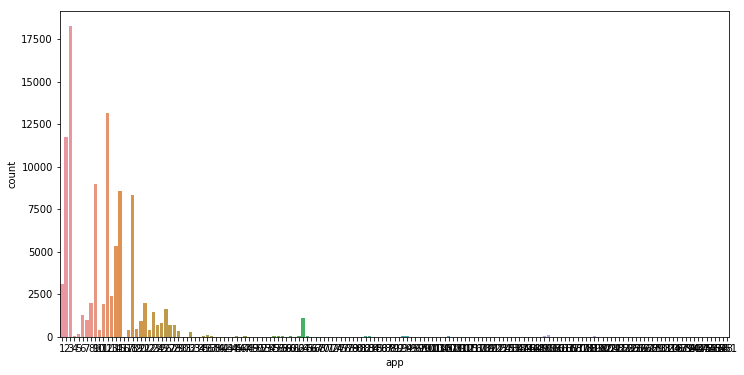

In [9]:
#count plot for apps

plt.figure(figsize = (12,6))
sns.countplot(x = 'app', data= train_short)

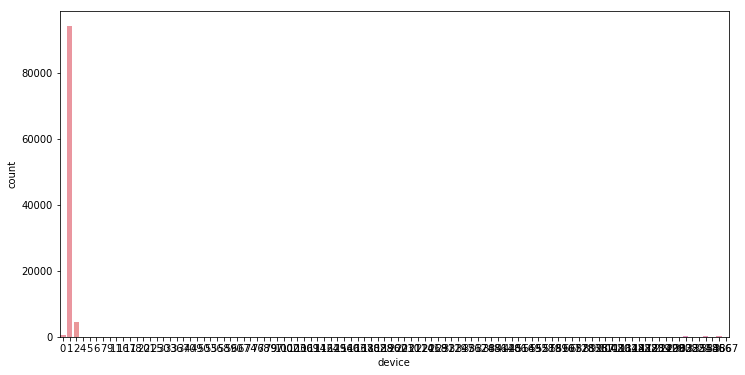

In [10]:
#count plot for device
plt.figure(figsize = (12,6))
sns.countplot(x = 'device', data = train_short)

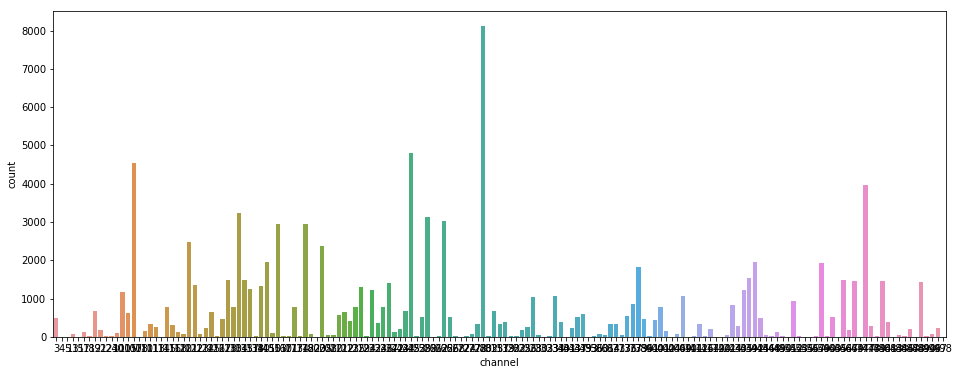

In [11]:
#count plot for channel
plt.figure(figsize = (16,6))
sns.countplot(x = 'channel', data = train_short)

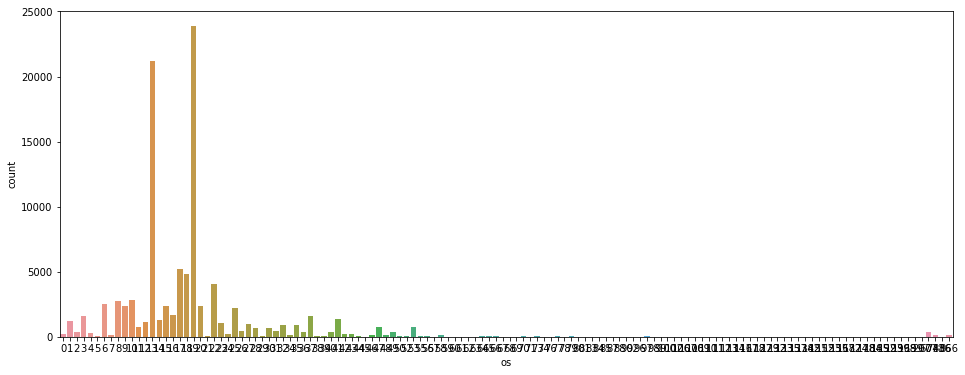

In [12]:
#count plot for os
plt.figure(figsize = (16,6))
sns.countplot(x = 'os', data = train_short)

In [13]:
#checking the distribution of target variable. 
train_short['is_attributed'].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

In [14]:
#garbage collection
gc.collect()

5

We can see that the target variable is highly imbalanced. Very few of the clicks are fraudlent.

### Feature Engineering

In [15]:
train_short.head()

,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,11/7/2017 9:30,0
1,105560,25,1,17,259,11/7/2017 13:40,0
2,101424,12,1,19,212,11/7/2017 18:05,0
3,94584,13,1,13,477,11/7/2017 4:58,0
4,68413,12,1,1,178,11/9/2017 9:00,0


In [16]:
#applying the datetime function to click_time column
train_short['date_time'] = pd.to_datetime(train_short['click_time'])

In [17]:
train_short.head()

,ip,app,device,os,channel,click_time,is_attributed,date_time
0,87540,12,1,13,497,11/7/2017 9:30,0,2017-11-07 09:30:00
1,105560,25,1,17,259,11/7/2017 13:40,0,2017-11-07 13:40:00
2,101424,12,1,19,212,11/7/2017 18:05,0,2017-11-07 18:05:00
3,94584,13,1,13,477,11/7/2017 4:58,0,2017-11-07 04:58:00
4,68413,12,1,1,178,11/9/2017 9:00,0,2017-11-09 09:00:00


In [18]:
#creating day of week column
train_short['day_of_week'] = train_short['date_time'].dt.dayofweek

In [19]:
#creating day of year column
train_short['day_of_year'] = train_short['date_time'].dt.dayofyear

In [20]:
#creating month and hour columns
train_short['month'] = train_short['date_time'].dt.month
train_short['hour'] = train_short['date_time'].dt.hour

In [21]:
train_short.head()

,ip,app,device,os,channel,click_time,is_attributed,date_time,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,11/7/2017 9:30,0,2017-11-07 09:30:00,1,311,11,9
1,105560,25,1,17,259,11/7/2017 13:40,0,2017-11-07 13:40:00,1,311,11,13
2,101424,12,1,19,212,11/7/2017 18:05,0,2017-11-07 18:05:00,1,311,11,18
3,94584,13,1,13,477,11/7/2017 4:58,0,2017-11-07 04:58:00,1,311,11,4
4,68413,12,1,1,178,11/9/2017 9:00,0,2017-11-09 09:00:00,3,313,11,9


In [22]:
#dropping the orignal columns and keeping the new columns
train_short.drop(['click_time', 'date_time'], axis= 1, inplace= True)
train_short.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,87540,12,1,13,497,0,1,311,11,9
1,105560,25,1,17,259,0,1,311,11,13
2,101424,12,1,19,212,0,1,311,11,18
3,94584,13,1,13,477,0,1,311,11,4
4,68413,12,1,1,178,0,3,313,11,9


## Modelling

Now we will try different models after splitting the data into X and y

In [23]:
X = train_short.drop('is_attributed', axis = 1)
y = train_short['is_attributed']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 9)
(80000,)
(20000, 9)
(20000,)


## Adaboost

In [26]:
#instantiate the decision tree model(weak learner)
tree = DecisionTreeClassifier(max_depth= 2)

#initialize the adaboost model with 600 estimators
adaboost_model_1 = AdaBoostClassifier(base_estimator= tree, n_estimators= 600,
                                      learning_rate= 1.5, algorithm= 'SAMME')

In [27]:
adaboost_model_1.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.5, n_estimators=600, random_state=None)

In [28]:
#predictions

predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.5260535 , 0.4739465 ],
       [0.53041856, 0.46958144],
       [0.53707542, 0.46292458],
       [0.51753107, 0.48246893],
       [0.51748243, 0.48251757],
       [0.52021342, 0.47978658],
       [0.52098069, 0.47901931],
       [0.51831049, 0.48168951],
       [0.53035032, 0.46964968],
       [0.51384159, 0.48615841]])

In [29]:
#judging the ROC score

metrics.roc_auc_score(y_test, predictions[:,1])

0.9405373200812941

In [30]:
gc.collect()

7

### Hyper Parameter tuning for Adaboost

In [31]:
#parameters grid

parameters = {'base_estimator__max_depth': [2,5], 
             'n_estimators': [200, 400, 600]}

tree = DecisionTreeClassifier()

ABC = AdaBoostClassifier(base_estimator= tree, learning_rate= 0.6, algorithm= 'SAMME')

In [32]:
folds = 3

grid_search_ABC = GridSearchCV(estimator= ABC, cv= folds, param_grid= parameters, scoring= 'roc_auc',
                              return_train_score= True, verbose= True)

In [33]:
grid_search_ABC.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  8.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'base_estimator__max_depth': [2, 5], 'n_estimators': [200, 400, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

In [34]:
#convert results to a data frame

cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,8.705271,0.263827,0.257506,0.006124,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.938241,0.961817,0.946352,0.948803,0.009780,1,0.996252,0.993546,0.996335,0.995378,0.001296
1,18.565160,0.580714,0.492030,0.013191,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.935249,0.960346,0.947850,0.947815,0.010246,2,0.997495,0.996649,0.997636,0.997260,0.000436
2,25.145082,0.589852,0.699901,0.001698,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.936550,0.957551,0.947384,0.947161,0.008575,3,0.997844,0.997641,0.997956,0.997814,0.000130
3,17.453516,0.376581,0.323800,0.002159,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.913702,0.944349,0.944359,0.934137,0.014450,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,34.686501,0.369528,0.616286,0.002055,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.910247,0.942935,0.935629,0.929604,0.014009,5,1.000000,1.000000,1.000000,1.000000,0.000000
5,52.034749,0.519599,0.908770,0.005309,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.913624,0.937506,0.931329,0.927486,0.010122,6,1.000000,1.000000,1.000000,1.000000,0.000000


In [35]:
max_depth_2 = cv_results[cv_results['param_base_estimator__max_depth'] == 2]
max_depth_5 = cv_results[cv_results['param_base_estimator__max_depth'] == 5]

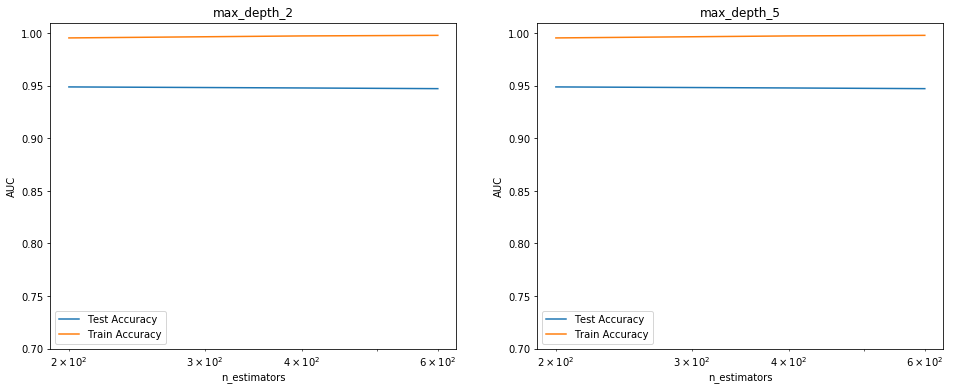

In [36]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)

plt.plot(max_depth_2['param_n_estimators'], max_depth_2['mean_test_score'], label = 'Test Accuracy')
plt.plot(max_depth_2['param_n_estimators'], max_depth_2['mean_train_score'], label = 'Train Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend(loc = 'lower left')
plt.ylim([0.7, 1.01])
plt.xscale('log')
plt.title('max_depth_2')


plt.subplot(1,2,2)
plt.plot(max_depth_5['param_n_estimators'], max_depth_2['mean_test_score'], label = 'Test Accuracy')
plt.plot(max_depth_5['param_n_estimators'], max_depth_2['mean_train_score'], label = 'Train Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend(loc = 'lower left')
plt.ylim([0.7, 1.01])
plt.xscale('log')
plt.title('max_depth_5')

plt.show()

In [37]:
#now lets predict using the best parameters

# model performance on test data with chosen hyperparameters

# base estimator
tree = DecisionTreeClassifier(max_depth=2)

# adaboost with the tree as base estimator
# learning rate is arbitrarily set, we'll discuss learning_rate below
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    n_estimators=200,
    algorithm="SAMME")

ABC.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.6, n_estimators=200, random_state=None)

In [38]:
predictions = ABC.predict_proba(X_test)
predictions[:10]

array([[0.59192367, 0.40807633],
       [0.58790106, 0.41209894],
       [0.61660047, 0.38339953],
       [0.57435972, 0.42564028],
       [0.56734246, 0.43265754],
       [0.57694174, 0.42305826],
       [0.57691744, 0.42308256],
       [0.57810649, 0.42189351],
       [0.59051374, 0.40948626],
       [0.5675164 , 0.4324836 ]])

In [39]:
#roc auc
metrics.roc_auc_score(y_test,predictions[:,1])

0.9449032545449483

In [40]:
gc.collect()

9973

## Gradiant Boosting Classifier

In [41]:
# parameter grid
param_grid = {"learning_rate": [0.2, 0.6, 0.9],
              "subsample": [0.3, 0.6, 0.9]
             }

# adaboost with the tree as base estimator
GBC = GradientBoostingClassifier(max_depth=2, n_estimators=200)


# run grid search
folds = 3
grid_search_GBC = GridSearchCV(GBC, 
                               cv = folds,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

grid_search_GBC.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.2, 0.6, 0.9], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [42]:
#convert to df
cv_results = pd.DataFrame(grid_search_GBC.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.226245,0.089962,0.045305,0.001246,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.756457,0.851916,0.666134,0.758170,0.075855,4,0.811793,0.819929,0.697137,0.776287,0.056065
1,4.918619,0.040408,0.046306,0.000470,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.785340,0.865573,0.882539,0.844483,0.042391,3,0.757489,0.893916,0.834024,0.828477,0.055834
2,4.481889,0.024618,0.048970,0.000816,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.835257,0.884500,0.924903,0.881553,0.036657,2,0.856889,0.860768,0.940995,0.886217,0.038766
3,4.119781,0.066280,0.045305,0.000943,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.703169,0.745020,0.773186,0.740458,0.028766,5,0.643126,0.784126,0.809769,0.745674,0.073264
4,4.857657,0.027518,0.046638,0.000471,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.659409,0.623224,0.214839,0.499161,0.201584,7,0.607949,0.654670,0.235669,0.499430,0.187479


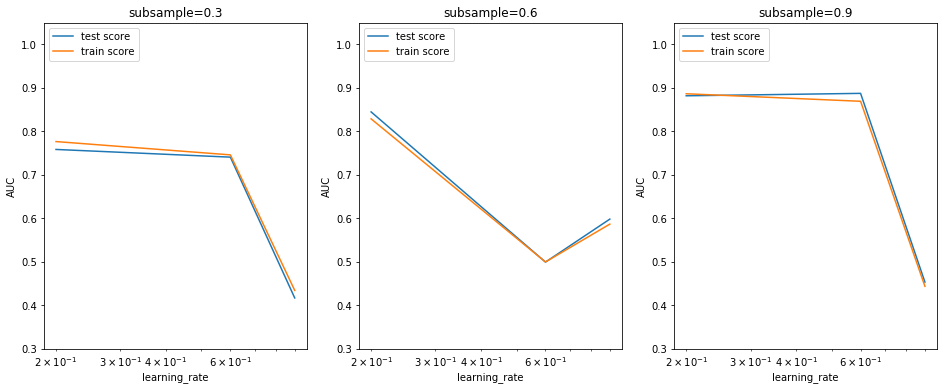

In [43]:

# # plotting
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.30, 1.05])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [44]:
gc.collect()

14333

## XGBoost


In [45]:
#training the model
model = XGBClassifier()
model.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [46]:
gc.collect()

7

In [47]:
#getting the predictions
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9987876e-01, 1.2123365e-04],
       [9.9979985e-01, 2.0012983e-04],
       [9.9988431e-01, 1.1571062e-04],
       [9.9909198e-01, 9.0801716e-04],
       [9.9929214e-01, 7.0787600e-04],
       [9.9978113e-01, 2.1887576e-04],
       [9.9963415e-01, 3.6587869e-04],
       [9.9934000e-01, 6.6002115e-04],
       [9.9957937e-01, 4.2064258e-04],
       [9.9824554e-01, 1.7544858e-03]], dtype=float32)

In [48]:
#accuracy roc auc
roc = metrics.roc_auc_score(y_test,y_pred[:,1])
print('the accuracy is {}'.format(round(roc*100),4))

the accuracy is 96.0


The roc_auc in this case is about 0.95% with default hyperparameters. Let's try changing the hyperparameters - an exhaustive list of XGBoost hyperparameters is here:
http://xgboost.readthedocs.io/en/latest/parameter.html

Let's now try tuning the hyperparameters using k-fold CV. We'll then use grid search CV to find the optimal values of hyperparameters.

### Hyper Parameter tuning with Xgboost

In [49]:
folds = 3

parameters = {'learning_rate': [0.2, 0.6], 'subsample': [0.3,0.6,0.9]}

xgb_model = XGBClassifier(max_depth= 2, n_estimators= 200)

model_cv = GridSearchCV(estimator= xgb_model, cv = folds, param_grid= parameters, 
                       scoring= 'roc_auc', verbose= True, return_train_score= True, n_jobs= -1)

In [50]:
model_cv.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   30.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.2, 0.6], 'subsample': [0.3, 0.6, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=True)

In [51]:
gc.collect()

337

In [52]:
#getting the results

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,4.992572,0.033459,0.179222,0.001246,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.921146,0.970444,0.963341,0.951643,0.021759,4,0.991252,0.989245,0.989623,0.990040,0.000871
1,5.689807,0.011663,0.173559,0.002623,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.935815,0.972853,0.952690,0.953786,0.015140,2,0.992543,0.988810,0.994370,0.991908,0.002314
2,5.370338,0.015184,0.172227,0.006015,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.941115,0.971283,0.950884,0.954427,0.012568,1,0.993562,0.988664,0.993417,0.991881,0.002276
3,4.955261,0.019608,0.180887,0.005711,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.929734,0.969810,0.953071,0.950871,0.016435,5,0.996487,0.993330,0.991717,0.993845,0.001981
4,5.663823,0.016205,0.178557,0.003857,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.936830,0.958551,0.955463,0.950281,0.009595,6,0.998927,0.998240,0.997782,0.998316,0.000471


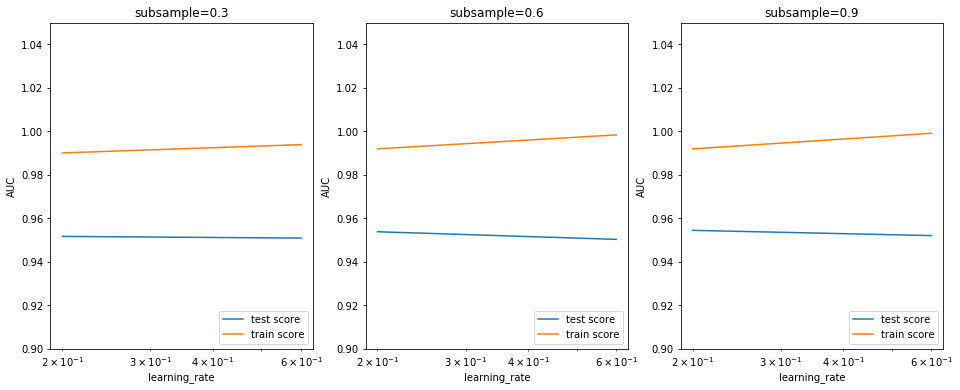

In [53]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.90, 1.05])
    plt.legend(['test score', 'train score'], loc='lower right')
    plt.xscale('log')

In [54]:
# lets built the final model with best hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.6, 'objective': 'binary:logistic'},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [55]:
gc.collect()

14026

In [56]:
# predict
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9987876e-01, 1.2123365e-04],
       [9.9979985e-01, 2.0012983e-04],
       [9.9988431e-01, 1.1571062e-04],
       [9.9909198e-01, 9.0801716e-04],
       [9.9929214e-01, 7.0787600e-04],
       [9.9978113e-01, 2.1887576e-04],
       [9.9963415e-01, 3.6587869e-04],
       [9.9934000e-01, 6.6002115e-04],
       [9.9957937e-01, 4.2064258e-04],
       [9.9824554e-01, 1.7544858e-03]], dtype=float32)

In [57]:
# roc_auc
auc = sklearn.metrics.roc_auc_score(y_test, y_pred[:, 1])
print('your accuracy is {}'.format(round(auc*100),3))

your accuracy is 96.0


In [58]:
X_train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'day_of_year',
       'month', 'hour'],
      dtype='object')

In [59]:
#getting the importance matrix
importance = pd.DataFrame()
importance['features'] = ['ip', 'app', 'device', 'os', 'channel', 'day_of_week', 'day_of_year',
       'month', 'hour']
importance['values'] = model.feature_importances_

In [60]:
importance

,features,values
0,ip,0.191153
1,app,0.308057
2,device,0.126382
3,os,0.069510
4,channel,0.213270
5,day_of_week,0.014218
6,day_of_year,0.000000
7,month,0.000000
8,hour,0.077409


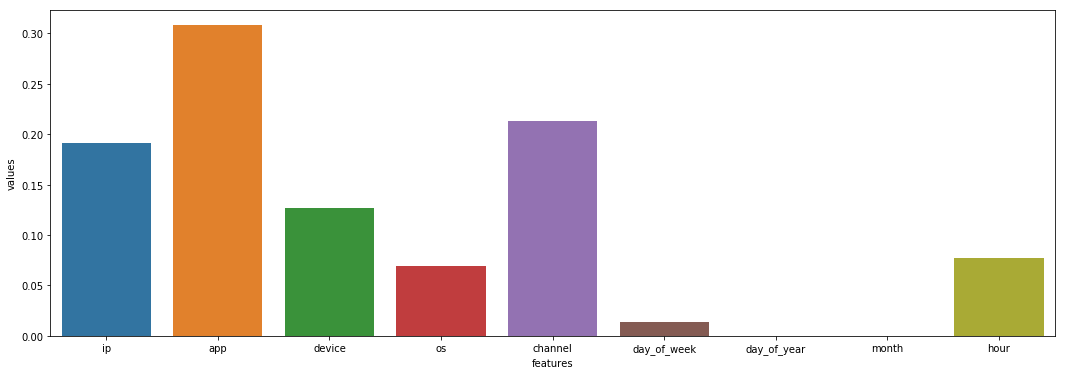

In [61]:
#plotting the importance of each feature
plt.figure(figsize = (18,6))
sns.barplot(x=importance['features'], y= importance['values'])

### Reading the Kaggle test file

In [62]:
#read as unint16 type to save memory
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'click_id'      : 'uint32' 
        }


test_kaggle = pd.read_csv('test_kag.csv', dtype=dtypes)

In [63]:
test_kaggle.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,54365,9,1,3,466,2017-11-10 04:00:00
2,2,6751,21,1,19,128,2017-11-10 04:00:00
3,3,12941,15,1,13,111,2017-11-10 04:00:00
4,4,57544,12,1,13,328,2017-11-10 04:00:00


In [64]:
test_kaggle.dtypes

click_id      uint32
ip            uint16
app           uint16
device        uint16
os            uint16
channel       uint16
click_time    object
dtype: object

In [65]:
#feature engineering to make more columns
test_kaggle['date_time'] = pd.to_datetime(test_kaggle['click_time'])

In [66]:
test_kaggle['day_of_week'] = test_kaggle['date_time'].dt.dayofweek
test_kaggle['day_of_year'] = test_kaggle['date_time'].dt.dayofyear
test_kaggle['month'] = test_kaggle['date_time'].dt.month
test_kaggle['hour'] = test_kaggle['date_time'].dt.hour

In [67]:
#drop the orignal columns
test_kaggle.drop(['click_time','date_time'], axis=1 , inplace= True)

In [68]:
test_kaggle.head()

,click_id,ip,app,device,os,channel,day_of_week,day_of_year,month,hour
0,0,5744,9,1,3,107,4,314,11,4
1,1,54365,9,1,3,466,4,314,11,4
2,2,6751,21,1,19,128,4,314,11,4
3,3,12941,15,1,13,111,4,314,11,4
4,4,57544,12,1,13,328,4,314,11,4


In [69]:
#checking the length of cols
len(test_kaggle['click_id'])

18790469

In [70]:
#data types check
test_kaggle.dtypes

click_id       uint32
ip             uint16
app            uint16
device         uint16
os             uint16
channel        uint16
day_of_week     int64
day_of_year     int64
month           int64
hour            int64
dtype: object

In [71]:
gc.collect()

79

In [72]:
#our model
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.6, 'objective': 'binary:logistic'},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [73]:
test_kaggle.drop('click_id', axis =1, inplace = True)

In [74]:
#getting the predictions for kaggle file

predictions = model.predict_proba(test_kaggle)

In [76]:
#first to predictions
predictions[:10]

array([[9.9952406e-01, 4.7592755e-04],
       [9.9935776e-01, 6.4226851e-04],
       [9.9880385e-01, 1.1961563e-03],
       [9.9967909e-01, 3.2091051e-04],
       [9.9967390e-01, 3.2610202e-04],
       [9.9965155e-01, 3.4846502e-04],
       [9.9955761e-01, 4.4238649e-04],
       [9.9888742e-01, 1.1125713e-03],
       [9.9962533e-01, 3.7466592e-04],
       [9.9968100e-01, 3.1900313e-04]], dtype=float32)

In [80]:
#convert into a df
predictions = pd.DataFrame(predictions, columns = ['yes', 'no'])

In [81]:
predictions.head()

,yes,no
0,0.999524,0.000476
1,0.999358,0.000642
2,0.998804,0.001196
3,0.999679,0.000321
4,0.999674,0.000326


In [84]:
#function to convert probabilities
def convert_prob(x):
    
    if x > 0.5:
        return 1
    else:
        return 0

In [86]:
#apply the convertor
predictions['is_attributed'] = predictions['no'].apply(convert_prob)

In [87]:
predictions.head()

,yes,no,is_attributed
0,0.999524,0.000476,0
1,0.999358,0.000642,0
2,0.998804,0.001196,0
3,0.999679,0.000321,0
4,0.999674,0.000326,0


In [88]:
#bringing into the desired format
predictions.drop(['yes','no'], axis = 1, inplace = True)

In [89]:
predictions.head()

,is_attributed
0,0
1,0
2,0
3,0
4,0


In [90]:
#submit the predictions
predictions.to_csv('my_kaggle_fin.csv')